# Case study: binaural sound localisation


In [1]:
from brian2 import *
import plot_utils
prefs.codegen.target = 'numpy'
%xmode minimal
defaultclock.dt = .02*ms

Exception reporting mode: Minimal


In [2]:
start_scope()
# Sound
sound = TimedArray(10 * np.sin(2*np.pi*440*Hz*np.arange(50000)*defaultclock.dt),
                   dt=defaultclock.dt) # pure tone at 440*Hz

# Ears with moving sound source
sound_speed = 300*metre/second
interaural_distance = 20*cm # big head!
max_delay = interaural_distance / sound_speed
angular_speed = 2 * pi / second # 1 turn/second
tau_ear = 1*ms; sigma_ear = .1

eqs_ears = '''
dx/dt = (delayed_sound-x)/tau_ear+sigma_ear*(2./tau_ear)**.5*xi : 1 (unless refractory)
delay = distance*sin(theta) : second
delayed_sound = sound(t-delay) : 1
distance : second  # distance to the centre of the head in time units
dtheta/dt = angular_speed : radian
'''
ears = NeuronGroup(2, eqs_ears, threshold='x>1', reset='x = 0',
                   refractory=2.5*ms, name='ears', method='euler')
ears.distance = [-.5 * max_delay, .5 * max_delay]
periphery_spikes = SpikeMonitor(ears)
sound_input = StateMonitor(ears, 'delayed_sound', record=True)

run(1000*ms)

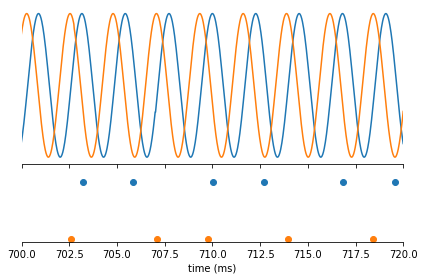

In [3]:
plot_utils.plot_periphery_model(sound_input, periphery_spikes, (700*ms, 720*ms))

In [4]:
start_scope()
# Sound
sound = TimedArray(10 * np.sin(2*np.pi*440*Hz*np.arange(50000)*defaultclock.dt),
                   dt=defaultclock.dt) # pure tone at 440*Hz

# Ears with moving sound source
sound_speed = 300*metre/second
interaural_distance = 20*cm # big head!
max_delay = interaural_distance / sound_speed
angular_speed = 2 * pi / second # 1 turn/second
tau_ear = 1*ms; sigma_ear = .1

eqs_ears = '''
dx/dt = (delayed_sound-x)/tau_ear+sigma_ear*(2./tau_ear)**.5*xi : 1 (unless refractory)
delay = distance*sin(theta) : second
delayed_sound = sound(t-delay) : 1
distance : second  # distance to the centre of the head in time units
dtheta/dt = angular_speed : radian
'''
ears = NeuronGroup(2, eqs_ears, threshold='x>1', reset='x = 0',
                   refractory=2.5*ms, name='ears', method='euler')
ears.distance = [-.5 * max_delay, .5 * max_delay]
periphery_spikes = SpikeMonitor(ears)
sound_input = StateMonitor(ears, ['delayed_sound', 'delay'], record=True)

# Coincidence detectors
num_neurons = 30
tau = 1*ms
sigma = .05
eqs_neurons = '''
dv/dt = -v / tau + sigma * (2 / tau)**.5 * xi : 1
'''
neurons = NeuronGroup(num_neurons, eqs_neurons, threshold='v>1',
                      reset='v = 0', name='neurons', method='euler')

synapses = Synapses(ears, neurons, on_pre='v += .5')
synapses.connect()

synapses.delay[0, :] = '(1.0*j)/(num_neurons-1)*1.1*max_delay'
synapses.delay[1, :] = '(1.0*(num_neurons-j-1))/(num_neurons-1)*1.1*max_delay'

spikes = SpikeMonitor(neurons)

run(1000*ms)

In [5]:
print(synapses.delay[0, :])
print(synapses.delay[1, :])

[  0.          25.28735632  50.57471264  75.86206897 101.14942529
 126.43678161 151.72413793 177.01149425 202.29885057 227.5862069
 252.87356322 278.16091954 303.44827586 328.73563218 354.02298851
 379.31034483 404.59770115 429.88505747 455.17241379 480.45977011
 505.74712644 531.03448276 556.32183908 581.6091954  606.89655172
 632.18390805 657.47126437 682.75862069 708.04597701 733.33333333] us
[733.33333333 708.04597701 682.75862069 657.47126437 632.18390805
 606.89655172 581.6091954  556.32183908 531.03448276 505.74712644
 480.45977011 455.17241379 429.88505747 404.59770115 379.31034483
 354.02298851 328.73563218 303.44827586 278.16091954 252.87356322
 227.5862069  202.29885057 177.01149425 151.72413793 126.43678161
 101.14942529  75.86206897  50.57471264  25.28735632   0.        ] us


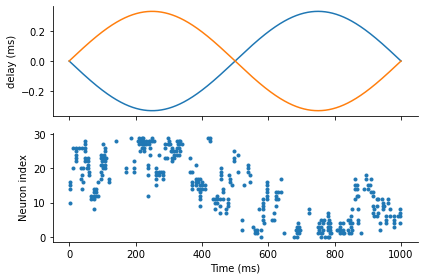

In [6]:
plot_utils.plot_sound_localisation(sound_input, spikes)